In [2]:
import numpy as np
import matplotlib.pyplot as plt

from cloudvolume import CloudVolume, view
import napari
%gui qt

In [3]:
SEGID=7
cv_skel = CloudVolume(
    'https://d2zu5izn76slwn.cloudfront.net/precomputed_volumes/brain1_segments',
    mip = 0,
    cache=False,
    parallel=False,
)
skel = cv_skel.skeleton.get(SEGID) 
#skel.viewer()

Downloading: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


In [3]:
def scale(verts):
    scales = cv.scales[1]['resolution']
    scaled = verts/scales
    int_scaled = [int(i) for i in scaled]
    return np.array(int_scaled).reshape(-1,1)

In [4]:
cv = CloudVolume(
    'https://d2zu5izn76slwn.cloudfront.net/precomputed_volumes/brain1',
    progress=True,
    mip = 0,
    cache=False,
    parallel=True,
)
cv.shape

Vec(33792,25600,13312,1, dtype=int64)

In [10]:
img = cv.download_point( scale(skel.vertices[5]), 
                        mip=1, size=(100,100,100),
                        coord_resolution=cv.scales[1]['resolution'])

Downloading:   0%|          | 0/3 [00:00<?, ?it/s]


In [6]:
np.any(np.unique(np.array(img)) != 0)

True

In [7]:
viewer = napari.view_image(np.squeeze(np.array(img)))
viewer.add_points(np.array([[i,50,50] for i in range(100)]), size=2)

<Points layer 'Points' at 0x12efc3828>

In [75]:
np.array(img).shape

(100, 100, 100, 1)

In [144]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()

    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]

        # the the number of components is 3 or 4 consider it an RGB image
        if c not in (3, 4):
            nda = nda[nda.shape[0] // 2, :, :]

    elif nda.ndim == 4:
        c = nda.shape[-1]

        if c not in (3, 4):
            raise RuntimeError("Unable to show 3D-vector Image")

        # take a z-slice
        nda = nda[nda.shape[0] // 2, :, :, :]

    xsize = nda.shape[1]*2
    ysize = nda.shape[0]*2

    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * xsize / dpi, (1 + margin) * ysize / dpi

    plt.figure(figsize=figsize, dpi=dpi, tight_layout=True)
    ax = plt.gca()

    extent = (0, xsize * spacing[0], ysize * spacing[1], 0)

    t = ax.imshow(nda, extent=extent, interpolation=None)

    if nda.ndim == 2:
        t.set_cmap("gray")

    if(title):
        plt.title(title)

    plt.show()


def myshow3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05,
             dpi=80):
    img_xslices = [img[s, :, :] for s in xslices]
    img_yslices = [img[:, s, :] for s in yslices]
    img_zslices = [img[:, :, s] for s in zslices]

    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))


    img_null = sitk.Image([0, 0], img.GetPixelID(),
                          img.GetNumberOfComponentsPerPixel())

    img_slices = []
    d = 0

    if len(img_xslices):
        img_slices += img_xslices + [img_null] * (maxlen - len(img_xslices))
        d += 1

    if len(img_yslices):
        img_slices += img_yslices + [img_null] * (maxlen - len(img_yslices))
        d += 1

    if len(img_zslices):
        img_slices += img_zslices + [img_null] * (maxlen - len(img_zslices))
        d += 1

    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen, d])
        # TO DO check in code to get Tile Filter working with vector images
        else:
            img_comps = []
            for i in range(0, img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i)
                                for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen, d]))
            img = sitk.Compose(img_comps)

    myshow(img, title, margin, dpi)

In [145]:
import SimpleITK as sitk

In [ ]:
img_T1 = sitk.GetImageFromArray(np.squeeze(img), isVector=False)

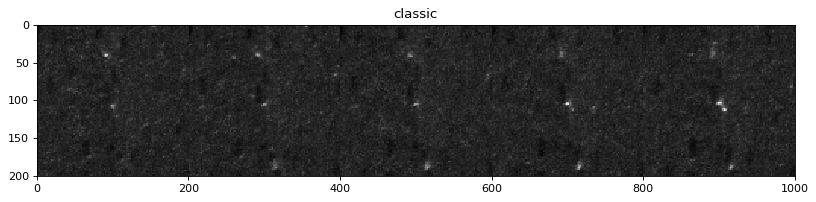

In [46]:
# To visualize the labels image in RGB needs a image with 0-255 range
img_T1_255 = sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8)

size = img_T1.GetSize()
myshow3d(img_T1_255, zslices=range(48, 53), title='classic')

In [64]:
seed = (50,50,50)
seg = sitk.Image(img_T1.GetSize(), sitk.sitkUInt8)
seg.CopyInformation(img_T1)
seg[seed] = 1
seg = sitk.BinaryDilate(seg, 1)

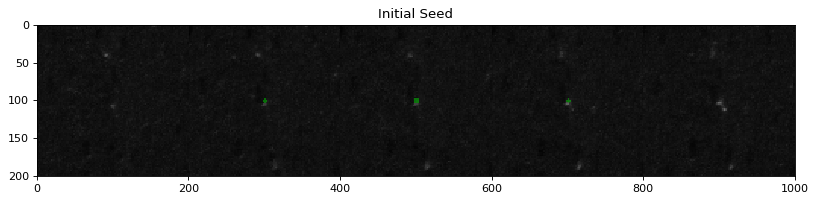

In [65]:
myshow3d(sitk.LabelOverlay(img_T1_255, seg),
         zslices=range(48, 53), title="Initial Seed")

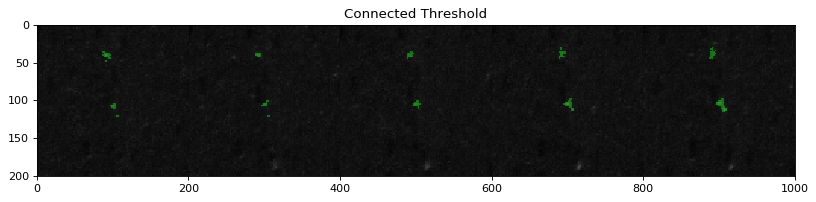

In [104]:
seg_con = sitk.ConnectedThreshold(img_T1_255, seedList=[seed],
                                  lower=28, upper=255)

myshow3d(sitk.LabelOverlay(img_T1_255, seg_con),
         zslices=range(48,53), title="Connected Threshold")

In [105]:
nda = sitk.GetArrayFromImage(seg_con)

In [106]:
viewer = napari.view_image(np.squeeze(np.array(img)))
viewer.add_labels(nda, name='segmentation')

<Labels layer 'segmentation' at 0x157db3748>

In [108]:
vectorRadius = (1, 1, 1)
kernel = sitk.sitkBall
seg_clean = sitk.BinaryMorphologicalClosing(seg_con,
                                            vectorRadius,
                                            kernel)

In [109]:
labels = sitk.GetArrayFromImage(seg_clean)

In [110]:
viewer = napari.view_image(np.squeeze(np.array(img)))
viewer.add_labels(labels, name='segmentation')

<Labels layer 'segmentation' at 0x1586cd630>

In [151]:
def up_to_img(seg_id, v_id):
    SEGID=seg_id
    cv_skel = CloudVolume(
        'https://d2zu5izn76slwn.cloudfront.net/precomputed_volumes/brain1_segments',
        mip = 0,
        cache=False,
        parallel=False,
    )
    skel = cv_skel.skeleton.get(SEGID) 
    
    cv = CloudVolume(
        'https://d2zu5izn76slwn.cloudfront.net/precomputed_volumes/brain1',
        progress=True,
        mip = 0,
        cache=False,
        parallel=True,
    )
    
    img = cv.download_point( scale(skel.vertices[v_id]), 
                        mip=1, size=(100,100,100),
                        coord_resolution=cv.scales[1]['resolution'])
    
    return img

In [152]:
def img_to_labels(img, low=28, up=255):
    img_T1 = sitk.GetImageFromArray(np.squeeze(img), isVector=False)
    img_T1_255 = sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8)
    seed = (50,50,50)
    seg = sitk.Image(img_T1.GetSize(), sitk.sitkUInt8)
    seg.CopyInformation(img_T1)
    seg[seed] = 1
    seg = sitk.BinaryDilate(seg, 1)
    seg_con = sitk.ConnectedThreshold(img_T1_255, seedList=[seed],
                                      lower=low, upper=up)
    vectorRadius = (1, 1, 1)
    kernel = sitk.sitkBall
    seg_clean = sitk.BinaryMorphologicalClosing(seg_con,
                                                vectorRadius,
                                                kernel)
    myshow3d(sitk.LabelOverlay(img_T1_255, seg_clean),
         zslices=range(48,53), title="Closed Connected Threshold")
    labels = sitk.GetArrayFromImage(seg_clean)
    return labels

In [ ]:
img = up_to_img(2, 100)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]
Downloading: 218it [00:22,  9.65it/s]                         
Downloading: 218it [00:25,  8.45it/s]                         
Downloading: 216it [00:27,  7.79it/s]                         
Downloading: 218it [00:28,  7.65it/s]                         
Downloading: 218it [00:29,  7.28it/s]                         
Downloading: 212it [00:30,  7.05it/s]                         
Downloading: 216it [00:34,  6.20it/s]                         


In [ ]:
labels = img_to_labels(img, 10)

In [150]:
viewer = napari.view_image(np.squeeze(np.array(img)))
viewer.add_labels(labels, name='segmentation')

<Labels layer 'segmentation' at 0x16f369e80>

In [ ]:
import numpy as np
from src import octree
from src import combine_swc_img
from src import read_swc
from src import visualize
from src import swc2voxel
from src import image_process
from scipy import ndimage as ndi
from matplotlib import pyplot as plt

im_path = '/cis/net/io50/data/janelia-data/2018-08-01'
tree = octree.octree(im_path)

swc_path = '/cis/net/io50/data/janelia-data/2018-08-01/swcs/17_9_19_consensus/2018-08-01-consensus-swcs/2018-08-01_G-007_consensus.swc'
df, _, _, _ = read_swc.read_swc_offset(swc_path)

num_pts = df.shape[0]

for i in range(0,num_pts,5):
    img,start = combine_swc_img.points2img(tree,df.iloc[i:i+5].reset_index())
    points = combine_swc_img.points2voxel(tree,df.iloc[i:i+5].reset_index(),start)
    voxels = points[['xvox','yvox','zvox']].values
    '''
    #Method 1
    processed,_ = swc2voxel.point_threshold(img, voxels)
    processed = swc2voxel.remove_small_components(processed)
    visualize.plot_image_pts([img, processed],voxels,
        titles = ['Image', 'Thresholded'])
    plt.show()
    '''
    #Method 2
    #img = ndi.filters.gaussian_filter(img,sigma=1)
    #img is a 3d array (x, y, z)
    #voxel is a list of points in 3d [(x1,y1,z1), (x2, y2, z2)]
    
    
    skel = swc2voxel.skeletonize(img, points)
    
    dilated = ndi.morphology.binary_dilation(skel,iterations=5)

    point_thresholded,_ = swc2voxel.point_threshold(img, points)
    point_thresholded = swc2voxel.remove_small_components(point_thresholded)

    intersect, intersect_iter = swc2voxel.skeleton_threshold_intersect(img,points) 

    closed = ndi.morphology.binary_closing(intersect,iterations=3)

    #f,a = visualize.plot_image_pts([img, skel, dilated, point_thresholded, intersect,closed],voxels, rows=2,
    #    titles = ['Image','Skeleton','Dilated','Thresholded at Minimum Point','Intersection','Closed Intersection'])
    f,a = visualize.plot_image_pts([img,intersect],voxels, rows=1,
        titles = ['Image','Intersection'])
    plt.show()